# Testing mcp_als on larger decompositions for groups of days

In [1]:
import tensortools as tt
import numpy as np
import flow
from flow.misc import wordhash
import pool
import pandas as pd
import os
from cascade import utils
from cascade import paths
from cascade import tca
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
import cascade as cas
cas.tca.groupday_tca('OA27', group_by='high_dprime_learning', method=('mcp_als',), rank=10)

TCA parameters hashed: clicks
Tensor decomp about to begin: tensor shape = (452, 108, 1815)


In [2]:
mouse='OA27'
tags=None

# TCA params
rank=20
method=('mcp_als',)
replicates=3
fit_options=None

# grouping params
group_by='high_dprime_learning'
up_or_down='up'
use_dprime=False
dprime_threshold=2

# tensor params
trace_type='zscore_day'
cs=''
downsample=True
start_time=-1
end_time=6
clean_artifacts=None
thresh=20
warp=False
smooth=True
smooth_win=5
verbose=True

# filtering params
exclude_tags=('disengaged', 'orientation_mapping', 'contrast', 'retinotopy', 'sated')
exclude_conds=('blank', 'blank_reward', 'pavlovian')
driven=True
drive_css=('0', '135', '270')
drive_threshold=15

In [3]:
"""
Perform tensor component analysis (TCA) on data aligned
across a group of days. Builds one large tensor.

Algortitms from https://github.com/ahwillia/tensortools.

Parameters
-------
methods, tuple of str
'cp_als', fits CP Decomposition using Alternating
    Least Squares (ALS).
'ncp_bcd', fits nonnegative CP Decomposition using
    the Block Coordinate Descent (BCD) Method.
'ncp_hals', fits nonnegtaive CP Decomposition using
    the Hierarcial Alternating Least Squares
    (HALS) Method.
'mcp_als', fits CP Decomposition with missing data using
    Alternating Least Squares (ALS).

rank, int
number of components you wish to fit

replicates, int
number of initializations/iterations fitting for each rank

Returns
-------

"""

# set grouping parameters
if group_by.lower() == 'naive':
    tags = 'naive'
    use_dprime = False
    exclude_tags = ('disengaged', 'orientation_mapping', 'contrast',
                    'retinotopy', 'sated', 'learning_start')

elif group_by.lower() == 'high_dprime_learning':
    use_dprime = True
    up_or_down = 'up'
    tags = 'learning'
    exclude_tags = ('disengaged', 'orientation_mapping', 'contrast',
                    'retinotopy', 'sated', 'reversal1_start')

elif group_by.lower() == 'low_dprime_leanring':
    use_dprime = True
    up_or_down = 'down'
    tags = 'learning'
    exclude_tags = ('disengaged', 'orientation_mapping', 'contrast',
                    'retinotopy', 'sated')

elif group_by.lower() == 'high_dprime_reversal1':
    use_dprime = True
    up_or_down = 'up'
    tags = 'reversal1'
    exclude_tags = ('disengaged', 'orientation_mapping', 'contrast',
                    'retinotopy', 'sated', 'reversal2_start')

elif group_by.lower() == 'low_dprime_reversal1':
    use_dprime = True
    up_or_down = 'down'
    tags = 'reversal1'
    exclude_tags = ('disengaged', 'orientation_mapping', 'contrast',
                    'retinotopy', 'sated')

elif group_by.lower() == 'high_dprime_reversal2':
    use_dprime = True
    up_or_down = 'up'
    tags = 'reversal2'
    exclude_tags = ('disengaged', 'orientation_mapping', 'contrast',
                    'retinotopy', 'sated')

elif group_by.lower() == 'low_dprime_reversal2':
    use_dprime = True
    up_or_down = 'down'
    tags = 'reversal2'
    exclude_tags = ('disengaged', 'orientation_mapping', 'contrast',
                    'retinotopy', 'sated')

elif group_by.lower() == 'naive_vs_high_dprime':
    use_dprime = True
    up_or_down = 'up'
    tags = None
    days = flow.DateSorter.frommeta(mice=[mouse], tags='naive')
    days.extend(flow.DateSorter.frommeta(mice=[mouse], tags='learning'))
    dates = set(days)
    exclude_tags = ('disengaged', 'orientation_mapping', 'contrast',
                    'retinotopy', 'sated', 'learning_start',
                    'reversal1_start')
elif group_by.lower() == 'l_vs_r1':  # high dprime
    use_dprime = True
    up_or_down = 'up'
    tags = None
    days = flow.DateSorter.frommeta(mice=[mouse], tags='learning')
    days.extend(flow.DateSorter.frommeta(mice=[mouse], tags='reversal1'))
    dates = set(days)
    exclude_tags = ('disengaged', 'orientation_mapping', 'contrast',
                    'retinotopy', 'sated', 'learning_start',
                    'reversal1_start')
else:
    print('Using input parameters without modification by group_by=...')

# create folder structure and save dir
if fit_options is None:
    fit_options = {'tol': 0.0001, 'max_iter': 500, 'verbose': False}
pars = {'tags': tags, 'rank': rank, 'method': method,
        'replicates': replicates, 'fit_options': fit_options,
        'trace_type': trace_type, 'cs': cs, 'downsample': downsample,
        'start_time': start_time, 'end_time': end_time,
        'clean_artifacts': clean_artifacts, 'thresh': thresh,
        'warp': warp, 'smooth': smooth, 'smooth_win': smooth_win,
        'exclude_tags': exclude_tags, 'exclude_conds': exclude_conds,
        'driven': driven, 'drive_css': drive_css,
        'drive_threshold': drive_threshold}
group_pars = {'group_by': group_by, 'up_or_down': up_or_down,
              'use_dprime': use_dprime, 'dprime_threshold': dprime_threshold}
save_dir = paths.tca_path(mouse, 'group', pars=pars, group_pars=group_pars)

# get DateSorter object
if np.isin(group_by.lower(), ['naive_vs_high_dprime', 'l_vs_r1']):
    days = flow.DateSorter(dates=dates)
else:
    days = flow.DateSorter.frommeta(mice=[mouse], tags=tags)

# filter DateSorter object if you are filtering on dprime
if use_dprime:
    dprime = []
    for day1 in days:
        # for comparison with naive make sure dprime keeps naive days
        if np.isin('naive', day1.tags):
            if up_or_down.lower() == 'up':
                dprime.append(np.inf)
            else:
                dprime.append(-np.inf)
        else:
            dprime.append(pool.calc.performance.dprime(day1))
    if up_or_down.lower() == 'up':
        days = [d for c, d in enumerate(days) if dprime[c] > dprime_threshold]
    elif up_or_down.lower() == 'down':
        days = [d for c, d in enumerate(days) if dprime[c] <= dprime_threshold]

# preallocate for looping over a group of days/runs
meta_list = []
tensor_list = []
id_list = []
for c, day1 in enumerate(days, 0):

    # get cell_ids
    d1_ids = flow.xday._read_crossday_ids(day1.mouse, day1.date)
    d1_ids = np.array([int(s) for s in d1_ids])

    # filter cells based on visual/trial drive across all cs, prevent
    # breaking when only pavs are shown
    if driven:
        good_ids = tca._group_drive_ids(days, drive_css, drive_threshold)
        d1_ids_bool = np.isin(d1_ids, good_ids)
        d1_sorter = np.argsort(d1_ids[d1_ids_bool])
    else:
        d1_ids_bool = np.ones(np.shape(d1_ids)) > 0
        d1_sorter = np.argsort(d1_ids[d1_ids_bool])
    ids = d1_ids[d1_ids_bool][d1_sorter]

    # TODO add in additional filter for being able to check for quality of xday alignment

    # get all runs for both days
    d1_runs = day1.runs()

    # filter for only runs without certain tags
    d1_runs = [run for run in d1_runs if not any(np.isin(run.tags, exclude_tags))]

    # build tensors for all correct runs and trials after filtering
    if d1_runs:
        d1_tensor_list = []
        d1_meta = []
        for run in d1_runs:
            t2p = run.trace2p()
            # trigger all trials around stimulus onsets
            run_traces = utils.getcstraces(run, cs=cs, trace_type=trace_type,
                                     start_time=start_time, end_time=end_time,
                                     downsample=True, clean_artifacts=clean_artifacts,
                                     thresh=thresh, warp=warp, smooth=smooth,
                                     smooth_win=smooth_win)
            # filter and sort
            run_traces = run_traces[d1_ids_bool, :, :][d1_sorter, :, :]
            # get matched trial metadata/variables
            dfr = tca._trialmetafromrun(run)
            # subselect metadata if you are only running certain cs
            if cs != '':
                if cs == 'plus' or cs == 'minus' or cs == 'neutral':
                    dfr = dfr.loc[(dfr['condition'].isin([cs])), :]
                elif cs == '0' or cs == '135' or cs == '270':
                    dfr = dfr.loc[(dfr['orientation'].isin([cs])), :]
                else:
                    print('ERROR: cs called - "' + cs + '" - is not\
                          a valid option.')

            # subselect metadata to remove certain condtions
            if len(exclude_conds) > 0:
                dfr = dfr.loc[(~dfr['condition'].isin([exclude_conds])), :]

            # drop trials with nans and add to lists
            keep = np.sum(np.sum(np.isnan(run_traces), axis=0, keepdims=True),
                          axis=1, keepdims=True).flatten() == 0
            dfr = dfr.iloc[keep, :]
            d1_tensor_list.append(run_traces[:, :, keep])
            d1_meta.append(dfr)

        # concatenate matched cells across trials 3rd dim (aka, 2)
        tensor = np.concatenate(d1_tensor_list, axis=2)

        # concatenate all trial metadata in pd dataframe
        meta = pd.concat(d1_meta, axis=0)

        meta_list.append(meta)
        tensor_list.append(tensor)
        id_list.append(ids)

# get total trial number across all days/runs
meta = pd.concat(meta_list, axis=0)
trial_num = len(meta.reset_index()['trial_idx'])

# get union of ids. Use these for indexing and splicing tensors together
id_union = np.unique(np.concatenate(id_list, axis=0))
cell_num = len(id_union)

# build a single large tensor leaving zeros where cell is not found
trial_start = 0
trial_end = 0
group_tensor = np.zeros((cell_num, np.shape(tensor_list[0])[1], trial_num))
group_tensor[:] = np.nan
for i in range(len(tensor_list)):
    trial_end += np.shape(tensor_list[i])[2]
    for c, k in enumerate(id_list[i]):
        celln_all_trials = tensor_list[i][c, :, :]
        group_tensor[(id_union == k), :, trial_start:trial_end] = celln_all_trials
    trial_start += np.shape(tensor_list[i])[2]

# just so you have a clue how big the tensor is
print('Tensor decomp about to begin: tensor shape = '
      + str(np.shape(group_tensor)))

# # concatenate and save df for the day
# meta_path = os.path.join(save_dir, str(day1.mouse) + '_'
#                          + str(group_by) + '_df_group_meta.pkl')
# input_tensor_path = os.path.join(save_dir, str(day1.mouse) + '_'
#                                  + str(group_by) + '_group_tensor_'
#                                  + str(trace_type) + '.npy')
# input_ids_path = os.path.join(save_dir, str(day1.mouse) + '_'
#                               + str(group_by) + '_group_ids_'
#                               + str(trace_type) + '.npy')
# output_tensor_path = os.path.join(save_dir, str(day1.mouse) + '_'
#                                   + str(group_by) + '_group_decomp_'
#                                   + str(trace_type) + '.npy')
# meta.to_pickle(meta_path)
# np.save(input_tensor_path, group_tensor)
# np.save(input_ids_path, id_union)

# # run TCA - iterate over different fitting methods
# if np.isin('mcp_als', fit_method):
#     mask = np.ones((cell_num, np.shape(tensor_list[0])[1], trial_num))
#     mask[np.isnan(group_tensor)] = 0
#     group_tensor[np.isnan(group_tensor)] = 0
    ensemble = {}
    results = {}
    for m in method:
#     mcp_als(group_tensor, rank, mask, **fit_options)
        for r in range(1, rank+1):
            results[r] =  mcp_als(group_tensor, rank, mask, **fit_options)
    ensemble[m] = results
# else:
#     ensemble = {}
#     for m in method:
#         ensemble[m] = tt.Ensemble(
#             fit_method=m, fit_options=deepcopy(fit_options))
#         ensemble[m].fit(group_tensor, ranks=range(1, rank+1), replicates=replicates, verbose=False)
#     np.save(output_tensor_path, ensemble)

# # print output so you don't go crazy waiting
# if verbose:
#     print(str(day1.mouse) + ': group_by=' + str(group_by) + ': done.')

TCA parameters hashed: cooper
Tensor decomp about to begin: tensor shape = (452, 108, 1815)


In [4]:
# run TCA - iterate over different fitting methods
if np.isin('mcp_als', method):
    print('yep')
    mask = np.ones((cell_num, np.shape(tensor_list[0])[1], trial_num))
    mask[np.isnan(group_tensor)] = 0
    group_tensor[np.isnan(group_tensor)] = 0
    test = tt.mcp_als(group_tensor, 10, mask, **fit_options)
    print('done.')

yep
done.


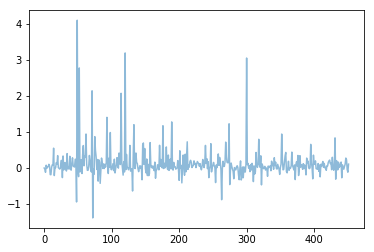

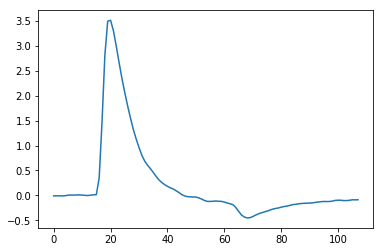

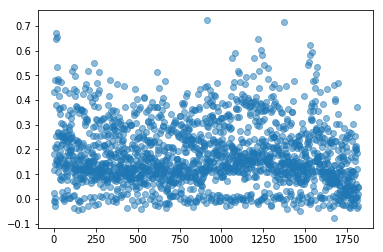

In [21]:
test.factors[1]
plt.figure()
plt.plot(test.factors[0][:,0], alpha=0.5)
plt.figure()
plt.plot(test.factors[1][:,0]*-1)
plt.figure()
plt.plot(test.factors[2][:,0]*-1, 'o', alpha=0.5)